In [48]:
# %pip install  langchain_openai langchain langgraph  joblib 'mlflow[databricks]'  azure-identity  pydantic  databricks-sdk  databricks-cli  python-dotenv  langchain_community   
# pygraphviz

In [49]:
# %pip install langchain_openai

In [50]:
from langchain_openai import AzureChatOpenAI
from langchain_core.messages import BaseMessage, HumanMessage, AIMessage, SystemMessage
from langgraph.graph import END, MessageGraph, StateGraph
 
from typing import List, Sequence
from langchain_core.prompts import ChatPromptTemplate, MessagesPlaceholder

import os
from dotenv import load_dotenv

# Load environment variables from .env file
load_dotenv()

True

In [51]:
# Define the state structure for StateGraph
from typing import TypedDict

class GraphState(TypedDict):
    messages: Sequence[BaseMessage]

In [52]:
# Configure ChatOpenAI for Azure OpenAI
deployment_name = "gpt-4o-mini"  # Replace with your actual deployment name

openai_llm = AzureChatOpenAI(
    azure_deployment=deployment_name,
    api_version=os.getenv("OPENAI_API_VERSION"),
    azure_endpoint=os.getenv("AZURE_OPENAI_ENDPOINT"),
    api_key=os.getenv("AZURE_OPENAI_API_KEY"),
    temperature=0.7,
    model_name=deployment_name,
    max_retries=3,
    request_timeout=120,
    max_tokens=1024,
    top_p=0.95   
)

Reflection is a method that helps AI improve its answers by reviewing and fixing them before finalizing. 

Instead of giving a quick response, the AI takes a moment to check its work, spot mistakes, and make improvements—similar to how people review and edit their own work.

In [53]:
# Creating the Chain for LinkedIn Post Generation
generation_prompt = ChatPromptTemplate.from_messages(
    [
        (
            "system",
            "You are a professional LinkedIn content assistant tasked with crafting engaging, insightful, and well-structured LinkedIn posts."
            " Generate the best LinkedIn post possible for the user's request."
            " If the user provides feedback or critique, respond with a refined version of your previous attempts, improving clarity, tone, or engagement as needed.",
        ),
        MessagesPlaceholder(variable_name="messages"),
    ]
)

In [54]:
# Creating the Generation Chain
generate_chain = generation_prompt | openai_llm

In [55]:
# Reflection Prompt for LinkedIn Post Critique
reflection_prompt = ChatPromptTemplate.from_messages([
    (
        "system",
        """You are a professional LinkedIn content strategist and thought leadership expert. Your task is to critically evaluate the given LinkedIn post and provide a comprehensive critique. Follow these guidelines:
 
        1. Assess the post’s overall quality, professionalism, and alignment with LinkedIn best practices.
        2. Evaluate the structure, tone, clarity, and readability of the post.
        3. Analyze the post’s potential for engagement (likes, comments, shares) and its effectiveness in building professional credibility.
        4. Consider the post’s relevance to the author’s industry, audience, or current trends.
        5. Examine the use of formatting (e.g., line breaks, bullet points), hashtags, mentions, and media (if any).
        6. Evaluate the effectiveness of any call-to-action or takeaway.
 
        Provide a detailed critique that includes:
        - A brief explanation of the post’s strengths and weaknesses.
        - Specific areas that could be improved.
        - Actionable suggestions for enhancing clarity, engagement, and professionalism.
 
        Your critique will be used to improve the post in the next revision step, so ensure your feedback is thoughtful, constructive, and practical.
        """
    ),
    MessagesPlaceholder(variable_name="messages")
])

In [56]:
# Creating the Reflect Chain
# The reflect_chain is created by combining the reflection_prompt with the language model (LLM). 
# This chain allows the model to evaluate and provide feedback on the generated post.

reflect_chain = reflection_prompt | openai_llm

In [57]:
# Initialize a StateGraph with the defined state structure
graph = StateGraph(GraphState)

The generation_node function acts as the starting point in the Reflection Agent's workflow. 

It generates an initial output based on the current state of the conversation, which contains all previous messages (user inputs, AI responses, and system instructions).

In [58]:
#  Defining the Generation and Reflection Node

def generation_node(state: GraphState) -> GraphState:
    generated_post = generate_chain.invoke({"messages": state["messages"]})
    return {"messages": [*state["messages"], AIMessage(content=generated_post.content)]}

The reflection_node function critiques the original output and makes recommendations for refinement. 

In [59]:
def reflection_node(state: GraphState) -> GraphState:
    res = reflect_chain.invoke({"messages": state["messages"]})  # Passes messages as input to reflect_chain
    return {"messages": [*state["messages"], HumanMessage(content=res.content)]}  # Returns the refined message as HumanMessage for feedback

In [60]:
#  determining whether the workflow should proceed to the reflection phase or terminate. 
def should_continue(state: GraphState):
    messages = state["messages"]
    print(f"Number of messages: {len(messages)}")
    print("----------------------------------------------------------------------")
    if len(messages) > 6:
        return END
    return "reflect"

In [61]:
graph.add_node("generate", generation_node)
graph.add_node("reflect", reflection_node)
graph.add_edge("reflect", "generate")
graph.set_entry_point("generate")

graph.add_conditional_edges("generate", should_continue)
workflow = graph.compile()


In [62]:
inputs = {"messages": [HumanMessage(content="""Write a linkedin post on getting a software developer job at IBM under 160 characters""")]}

In [63]:
response = workflow.invoke(inputs)
response

Number of messages: 2
----------------------------------------------------------------------
Number of messages: 4
----------------------------------------------------------------------
Number of messages: 4
----------------------------------------------------------------------
Number of messages: 6
----------------------------------------------------------------------
Number of messages: 6
----------------------------------------------------------------------
Number of messages: 8
----------------------------------------------------------------------
Number of messages: 8
----------------------------------------------------------------------


{'messages': [HumanMessage(content='Write a linkedin post on getting a software developer job at IBM under 160 characters', additional_kwargs={}, response_metadata={}),
  AIMessage(content='Thrilled to announce I’ve joined IBM as a Software Developer! Excited for the journey ahead and to innovate alongside a talented team. 🚀 #NewBeginnings #IBM #SoftwareDevelopment', additional_kwargs={}, response_metadata={}),
  HumanMessage(content='### Critique of the LinkedIn Post\n\n#### Overall Quality and Professionalism\nThe post effectively conveys excitement about a new job at IBM, which is a significant achievement in the tech industry. It maintains a professional tone, suitable for LinkedIn, and employs a positive and engaging approach. However, it could benefit from a slightly more personal touch to enhance authenticity and connection with the audience.\n\n#### Structure, Tone, Clarity, and Readability\nThe post is well-structured and concise, adhering to the 160-character limit. The tone 

In [64]:
print(response["messages"][1].content)

Thrilled to announce I’ve joined IBM as a Software Developer! Excited for the journey ahead and to innovate alongside a talented team. 🚀 #NewBeginnings #IBM #SoftwareDevelopment


In [65]:
print(response["messages"][2].content)

### Critique of the LinkedIn Post

#### Overall Quality and Professionalism
The post effectively conveys excitement about a new job at IBM, which is a significant achievement in the tech industry. It maintains a professional tone, suitable for LinkedIn, and employs a positive and engaging approach. However, it could benefit from a slightly more personal touch to enhance authenticity and connection with the audience.

#### Structure, Tone, Clarity, and Readability
The post is well-structured and concise, adhering to the 160-character limit. The tone is enthusiastic and celebratory, which is appropriate for sharing career milestones. The clarity is good, but the message could be enriched with a bit more context or personal insight.

#### Potential for Engagement
The use of emojis and hashtags increases the potential for engagement, making it visually appealing and searchable. However, the post could have included a question or prompt to encourage comments and shares, thereby enhancing in

In [66]:
print(response["messages"][-1].content)

Thank you for the thorough and constructive critique! I appreciate your insights and suggestions for enhancing engagement in future posts. Here’s the final version of the LinkedIn post, incorporating your feedback:

---

🚀 Excited to share that I've joined @IBM as a Software Developer! I’m eager to innovate and learn from such a talented team. What tips do you have for starting a new role in tech? #NewBeginnings #IBM #SoftwareDevelopment #TechJobs #CareerGrowth

---

For future posts, I’ll keep in mind the importance of incorporating media and varying hashtags to reach a wider audience. I also love the idea of sharing a follow-up post after settling into my new role to provide insights and foster ongoing engagement.

If you have any more suggestions or topics you'd like to explore, feel free to let me know! Thank you again for your guidance!


In [ ]:
# %pip install pygraphviz

Defaulting to user installation because normal site-packages is not writeable
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.


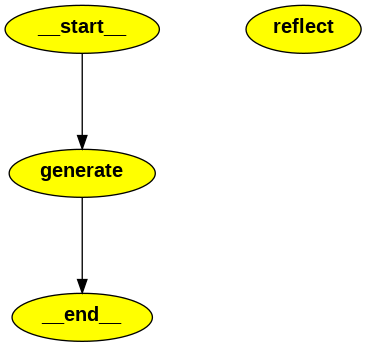

In [68]:
from IPython.display import Image, display

display(Image(workflow.get_graph().draw_png()))